# Part II: Investigating the Vanishing Gradient Problem [20 pts]
Experimentally demonstrate the vanishing gradient problem in deep CNNs and understand how ResNet's architecture mitigates it. You will also explore other key CNN concepts through additional experiments.

In [53]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np
import random

from torchsummary import summary

import pandas as pd

from sklearn.model_selection import train_test_split

from collections import defaultdict
import time

In [54]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [55]:
data_dir = './cnn_dataset'
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)

print(f"Total images: {len(dataset)}")
print(f"Classes: {dataset.classes}")
print(f"Class counts: {np.bincount(dataset.targets)}")


train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

Total images: 30000
Classes: ['dogs', 'food', 'vehicles']
Class counts: [10000 10000 10000]


## Step 1: Create a deeper version of your VGG-16 network (VGG-Deep)

In [56]:
# ### ADD YOUR CODE HERE ###

class VGGDeep(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1 (64)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2 (128)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3 (256) with 1x1 conv
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4 (512) - Original + 2 new convs
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=1),  # 1x1 conv (Version C)
            nn.ReLU(inplace=False),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, kernel_size=1),  # 1x1 conv (Version C)
            nn.ReLU(inplace=False),
            
            # Block 5 (512) - Original + 2 new convs
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            # Additional layers
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 8 * 8, 4096),  # Adjusted for 64x64 input
            nn.ReLU(inplace=False),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=False),

            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [57]:
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [58]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

In [59]:
model = VGGDeep().to(device)

In [60]:
summary(model, input_size=(3, 64, 64))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      65,792
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20               

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      65,792
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20               

In [61]:
model.apply(init_weights)

VGGDeep(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [62]:
grad_norms = defaultdict(list)
epoch_grad_norms = defaultdict(list)

def make_gradient_hook(layer_name):
    def hook_fn(module, grad_input, grad_output):
        if grad_output[0] is not None:
            grad_value = grad_output[0].norm(p=2).item()
            grad_norms[layer_name].append(grad_value)
    return hook_fn

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        module.register_full_backward_hook(make_gradient_hook(name))


In [63]:
criterion = nn.CrossEntropyLoss()

In [64]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [65]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Step 2: Training VGG-Deep

In [66]:
# Lists to store epoch-wise metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop with progress bar
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    # Training progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update metrics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        train_loop.set_postfix(loss=loss.item(), acc=correct/total)

    for layer_name, norms in grad_norms.items():
        epoch_avg = sum(norms) / len(norms)
        epoch_grad_norms[layer_name].append(epoch_avg)
    grad_norms.clear()
    
    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update metrics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

    # Calculate epoch metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = 100. * correct / total
    val_acc = 100. * val_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")


Epoch 1 | Train Loss: 0.9546, Acc: 57.57% | Val Loss: 0.9532, Acc: 57.67%


Epoch 2 | Train Loss: 0.8124, Acc: 73.12% | Val Loss: 0.7609, Acc: 78.87%


Epoch 3 | Train Loss: 0.7753, Acc: 76.70% | Val Loss: 0.7714, Acc: 77.44%


Epoch 4 | Train Loss: 0.7535, Acc: 79.20% | Val Loss: 0.7478, Acc: 79.93%


Epoch 5 | Train Loss: 0.7371, Acc: 80.88% | Val Loss: 0.7597, Acc: 78.76%


Epoch 6 | Train Loss: 0.7223, Acc: 82.44% | Val Loss: 0.7761, Acc: 76.73%


Epoch 7 | Train Loss: 0.7079, Acc: 84.17% | Val Loss: 0.7908, Acc: 75.27%


Epoch 8 | Train Loss: 0.7007, Acc: 84.69% | Val Loss: 0.6939, Acc: 85.40%


Epoch 9 | Train Loss: 0.6884, Acc: 85.97% | Val Loss: 0.9083, Acc: 63.64%


Epoch 10 | Train Loss: 0.6826, Acc: 86.53% | Val Loss: 0.9457, Acc: 58.96%


<span style='color:green'>### YOUR ANSWER ###</span>

## Step 3: Gradient analysis

- Track the average L2 norm of the gradients in each convolutional layer using PyTorch hooks.

- Create a plot showing the average gradient norm for each convolutional layer over time.

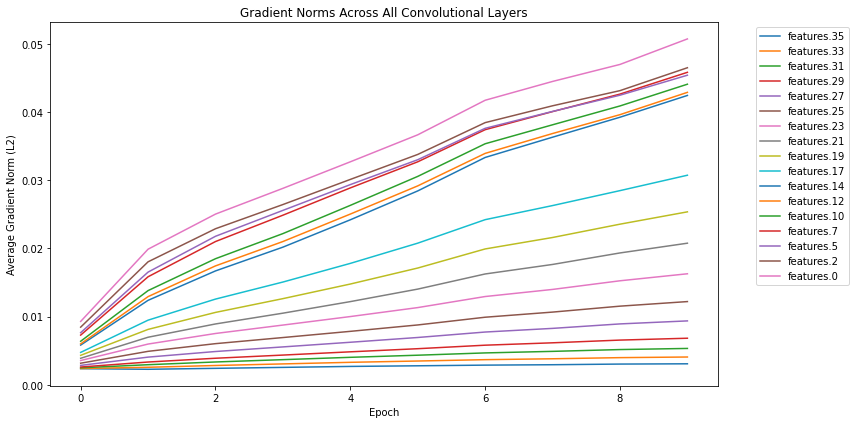

In [67]:
plt.figure(figsize=(12, 6))
for layer_name, gradients in epoch_grad_norms.items():
    plt.plot(gradients, label=layer_name)

plt.xlabel("Epoch")
plt.ylabel("Average Gradient Norm (L2)")
plt.title("Gradient Norms Across All Convolutional Layers")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


- Create a separate plot showing the gradient norms for a subset of layers.

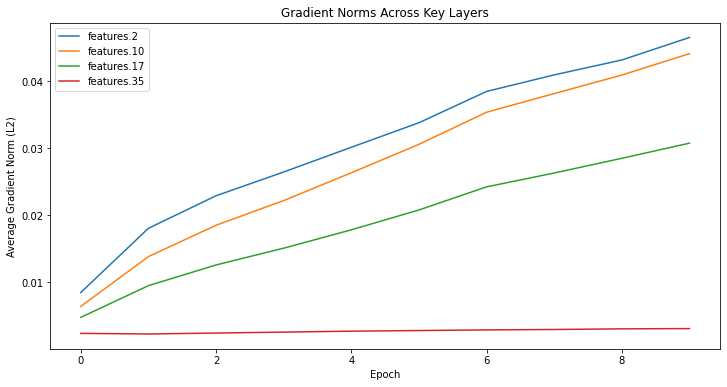

In [68]:
selected_layers = ["features.2", "features.10", "features.17", "features.35"]

plt.figure(figsize=(12, 6))
for layer_name in selected_layers:
    if layer_name in epoch_grad_norms:
        plt.plot(epoch_grad_norms[layer_name], label=layer_name)

plt.xlabel("Epoch")
plt.ylabel("Average Gradient Norm (L2)")
plt.title("Gradient Norms Across Key Layers")
plt.legend(loc="best")
plt.show()


<span style='color:green'>### YOUR ANSWER ###</span>

## Step 4: Comparison with VGG-16 and ResNet-18

- Compare the training curves (loss and accuracy vs. epoch) of VGG-Deep, VGG-16, and ResNet-18.

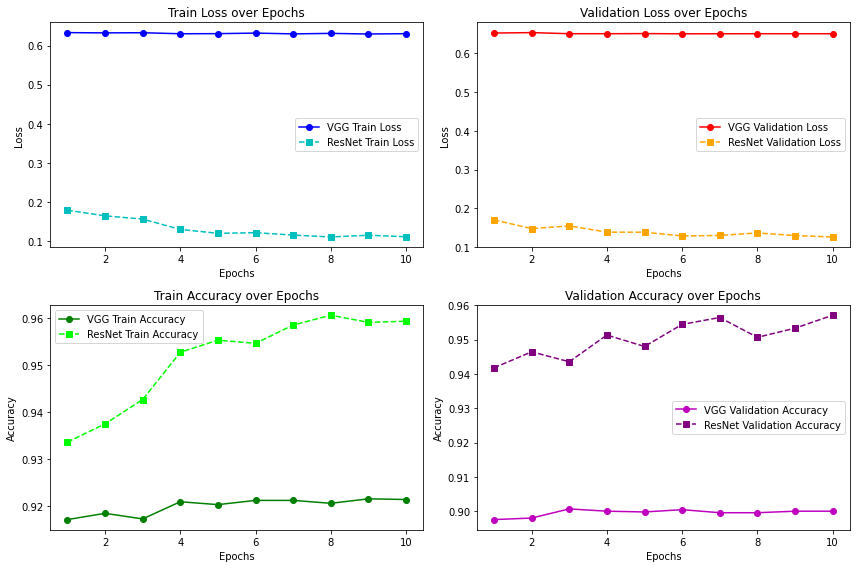

In [74]:
import json
import matplotlib.pyplot as plt

# Load the JSON files
with open("VGG.json", "r") as f:
    VGG_data = json.load(f)

with open("ResNet.json", "r") as f:
    ResNet_data = json.load(f)

# Extract values from both models
train_losses_vgg = VGG_data["train_losses"]
val_losses_vgg = VGG_data["val_losses"]
train_accs_vgg = VGG_data["train_accs"]
val_accs_vgg = VGG_data["val_accs"]

train_losses_resnet = ResNet_data["train_losses"]
val_losses_resnet = ResNet_data["val_losses"]
train_accs_resnet = ResNet_data["train_accs"]
val_accs_resnet = ResNet_data["val_accs"]

epochs = range(1, len(train_losses_vgg) + 1)  

plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses_vgg, marker="o", linestyle="-", color="b", label="VGG Train Loss")
plt.plot(epochs, train_losses_resnet, marker="s", linestyle="--", color="c", label="ResNet Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss over Epochs")
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses_vgg, marker="o", linestyle="-", color="r", label="VGG Validation Loss")
plt.plot(epochs, val_losses_resnet, marker="s", linestyle="--", color="orange", label="ResNet Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(epochs, train_accs_vgg, marker="o", linestyle="-", color="g", label="VGG Train Accuracy")
plt.plot(epochs, train_accs_resnet, marker="s", linestyle="--", color="lime", label="ResNet Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy over Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, val_accs_vgg, marker="o", linestyle="-", color="m", label="VGG Validation Accuracy")
plt.plot(epochs, val_accs_resnet, marker="s", linestyle="--", color="purple", label="ResNet Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

- Discuss how ResNet’s residual connections impact the gradient flow compared to VGG-Deep.

<span style='color:green'>### YOUR ANSWER ###</span>

## Step 5: Investigate and analyze more setups

- Select any THREE experiments to investigate and analyze.

In [19]:
train_subset_idx, temp_subset_idx = train_test_split(range(len(dataset)), train_size=3000, test_size=900, random_state=42)

val_subset_idx, test_subset_idx = train_test_split(temp_subset_idx, train_size=450, test_size=450, random_state=42)

train_subset_dataset = torch.utils.data.Subset(dataset, train_subset_idx)
val_subset_dataset = torch.utils.data.Subset(dataset, val_subset_idx)
test_subset_dataset = torch.utils.data.Subset(dataset, test_subset_idx)


train_subset_loader = DataLoader(train_subset_dataset, batch_size=32, shuffle=True)
val_subset_loader = DataLoader(val_subset_dataset, batch_size=32)
test_subset_loader = DataLoader(test_subset_dataset, batch_size=32)

In [20]:
import torch
import torch.nn as nn

class VGGSmallExp(nn.Module):
    def __init__(self, pool_type='max', activation='relu', kernel_size=3):
        super(VGGSmallExp, self).__init__()
        
        self.pool = nn.MaxPool2d if pool_type == 'max' else nn.AvgPool2d
        
        self.activation_config = {
            'relu': (nn.ReLU, {}),
            'leaky': (nn.LeakyReLU, {'negative_slope': 0.01}),
            'elu': (nn.ELU, {'alpha': 1.0}),
            'gelu': (nn.GELU, {})
        }
        assert activation in self.activation_config, f"Unsupported activation: {activation}"
        
        act_class, act_params = self.activation_config[activation]
        self.act = act_class(**act_params)

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size, padding=1),
            self.act,
            nn.Conv2d(64, 128, kernel_size, padding=1),
            self.act,
            nn.Conv2d(128, 256, kernel_size, padding=1),
            self.act,
            self.pool(kernel_size=2, stride=2)
        )

        conv_output_size = self._get_conv_output_size((3, 64, 64))

        self.classifier = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            self.act,
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            self.act,
            nn.Dropout(0.5),
            nn.Linear(512, 3),
        )

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 64, 64)
            dummy_output = self.features(dummy_input)
            return dummy_output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
                
                tepoch.set_postfix(lr=optimizer.param_groups[0]['lr'], loss=loss.item())
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        train_acc = correct / total
        train_accs.append(train_acc)

       
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {(time.time() - epoch_start):.1f}s")

    return train_losses, val_losses, train_accs, val_accs

In [22]:
def test_model(model, test_loader):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else 
                          "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    correct, total = 0, 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_loss /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

In [23]:
criterion = nn.CrossEntropyLoss()
num_epochs = 10

### Experiment 1

In [24]:
### ADD YOUR CODE HERE ###

# Kernal_size = 3

model_kernal3 = VGGSmallExp(kernel_size=3).to(device)

optimizer = optim.SGD(model_kernal3.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_kernal3, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler,num_epochs)

k3_test_loss, k3_test_acc = test_model(model_kernal3, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 39.94batch/s, loss=0.85, lr=0.01] 


Epoch [1/10], Train Loss: 1.0423, Train Acc: 0.4347, Val Loss: 0.8144, Val Acc: 0.6133, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 40.83batch/s, loss=0.808, lr=0.01]


Epoch [2/10], Train Loss: 0.7387, Train Acc: 0.6793, Val Loss: 0.6183, Val Acc: 0.7444, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 37.27batch/s, loss=0.642, lr=0.001]


Epoch [3/10], Train Loss: 0.6132, Train Acc: 0.7393, Val Loss: 0.5650, Val Acc: 0.7556, Time: 2.7s


100%|██████████| 94/94 [00:02<00:00, 43.13batch/s, loss=0.403, lr=0.001]


Epoch [4/10], Train Loss: 0.5782, Train Acc: 0.7473, Val Loss: 0.5733, Val Acc: 0.7444, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 44.17batch/s, loss=0.652, lr=0.0001]


Epoch [5/10], Train Loss: 0.5598, Train Acc: 0.7647, Val Loss: 0.5460, Val Acc: 0.7556, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 42.41batch/s, loss=0.549, lr=0.0001]


Epoch [6/10], Train Loss: 0.5590, Train Acc: 0.7630, Val Loss: 0.5423, Val Acc: 0.7600, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 42.84batch/s, loss=0.449, lr=1e-5]


Epoch [7/10], Train Loss: 0.5495, Train Acc: 0.7637, Val Loss: 0.5418, Val Acc: 0.7622, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 37.97batch/s, loss=0.673, lr=1e-5]


Epoch [8/10], Train Loss: 0.5531, Train Acc: 0.7597, Val Loss: 0.5418, Val Acc: 0.7622, Time: 2.8s


100%|██████████| 94/94 [00:02<00:00, 41.76batch/s, loss=0.601, lr=1e-6]


Epoch [9/10], Train Loss: 0.5504, Train Acc: 0.7747, Val Loss: 0.5417, Val Acc: 0.7622, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 42.54batch/s, loss=0.39, lr=1e-6] 


Epoch [10/10], Train Loss: 0.5455, Train Acc: 0.7763, Val Loss: 0.5417, Val Acc: 0.7622, Time: 2.4s
Test Loss: 0.5615, Test Accuracy: 0.7578


In [25]:
# Kernal_size = 5
model_kernal5 = VGGSmallExp(kernel_size=5).to(device)

optimizer = optim.SGD(model_kernal5.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_kernal5, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

k5_test_loss, k5_test_acc = test_model(model_kernal5, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 37.59batch/s, loss=0.9, lr=0.01]  


Epoch [1/10], Train Loss: 1.0158, Train Acc: 0.4630, Val Loss: 0.8544, Val Acc: 0.6378, Time: 2.7s


100%|██████████| 94/94 [00:02<00:00, 41.34batch/s, loss=0.632, lr=0.01]


Epoch [2/10], Train Loss: 0.8727, Train Acc: 0.5993, Val Loss: 0.9305, Val Acc: 0.4556, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 35.88batch/s, loss=0.645, lr=0.001]


Epoch [3/10], Train Loss: 0.7657, Train Acc: 0.6623, Val Loss: 0.6620, Val Acc: 0.6956, Time: 2.9s


100%|██████████| 94/94 [00:02<00:00, 39.45batch/s, loss=0.83, lr=0.001] 


Epoch [4/10], Train Loss: 0.7004, Train Acc: 0.7003, Val Loss: 0.6548, Val Acc: 0.7111, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 40.04batch/s, loss=0.467, lr=0.0001]


Epoch [5/10], Train Loss: 0.6696, Train Acc: 0.7193, Val Loss: 0.6154, Val Acc: 0.7378, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 40.78batch/s, loss=0.538, lr=0.0001]


Epoch [6/10], Train Loss: 0.6676, Train Acc: 0.7270, Val Loss: 0.6109, Val Acc: 0.7489, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 39.38batch/s, loss=0.648, lr=1e-5]


Epoch [7/10], Train Loss: 0.6717, Train Acc: 0.7303, Val Loss: 0.6107, Val Acc: 0.7400, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 38.36batch/s, loss=0.571, lr=1e-5]


Epoch [8/10], Train Loss: 0.6649, Train Acc: 0.7217, Val Loss: 0.6107, Val Acc: 0.7378, Time: 2.8s


100%|██████████| 94/94 [00:02<00:00, 31.78batch/s, loss=0.515, lr=1e-6]


Epoch [9/10], Train Loss: 0.6597, Train Acc: 0.7280, Val Loss: 0.6106, Val Acc: 0.7378, Time: 3.2s


100%|██████████| 94/94 [00:02<00:00, 38.96batch/s, loss=0.63, lr=1e-6] 


Epoch [10/10], Train Loss: 0.6611, Train Acc: 0.7247, Val Loss: 0.6106, Val Acc: 0.7378, Time: 2.6s
Test Loss: 0.6520, Test Accuracy: 0.7378


In [26]:
# Kernal_size = 7
model_kernal7 = VGGSmallExp(kernel_size=7).to(device)

optimizer = optim.SGD(model_kernal7.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_kernal7, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

k7_test_loss, k7_test_acc = test_model(model_kernal7, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 36.20batch/s, loss=1.06, lr=0.01] 


Epoch [1/10], Train Loss: 1.0890, Train Acc: 0.4000, Val Loss: 1.0507, Val Acc: 0.5778, Time: 2.9s


100%|██████████| 94/94 [00:02<00:00, 39.90batch/s, loss=0.926, lr=0.01]


Epoch [2/10], Train Loss: 0.9048, Train Acc: 0.5963, Val Loss: 0.8000, Val Acc: 0.6333, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 37.76batch/s, loss=0.738, lr=0.001]


Epoch [3/10], Train Loss: 0.7613, Train Acc: 0.6470, Val Loss: 0.7068, Val Acc: 0.6356, Time: 2.7s


100%|██████████| 94/94 [00:02<00:00, 38.75batch/s, loss=0.842, lr=0.001]


Epoch [4/10], Train Loss: 0.7433, Train Acc: 0.6567, Val Loss: 0.7223, Val Acc: 0.6844, Time: 2.7s


100%|██████████| 94/94 [00:02<00:00, 38.86batch/s, loss=0.637, lr=0.0001]


Epoch [5/10], Train Loss: 0.7342, Train Acc: 0.6647, Val Loss: 0.6904, Val Acc: 0.6622, Time: 2.7s


100%|██████████| 94/94 [00:02<00:00, 37.13batch/s, loss=0.786, lr=0.0001]


Epoch [6/10], Train Loss: 0.7225, Train Acc: 0.6703, Val Loss: 0.6873, Val Acc: 0.6667, Time: 2.8s


100%|██████████| 94/94 [00:02<00:00, 37.07batch/s, loss=0.784, lr=1e-5]


Epoch [7/10], Train Loss: 0.7239, Train Acc: 0.6660, Val Loss: 0.6872, Val Acc: 0.6667, Time: 2.8s


100%|██████████| 94/94 [00:02<00:00, 39.18batch/s, loss=0.797, lr=1e-5]


Epoch [8/10], Train Loss: 0.7222, Train Acc: 0.6663, Val Loss: 0.6872, Val Acc: 0.6689, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 39.41batch/s, loss=0.75, lr=1e-6] 


Epoch [9/10], Train Loss: 0.7276, Train Acc: 0.6717, Val Loss: 0.6872, Val Acc: 0.6689, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 38.58batch/s, loss=0.925, lr=1e-6]


Epoch [10/10], Train Loss: 0.7280, Train Acc: 0.6683, Val Loss: 0.6872, Val Acc: 0.6689, Time: 2.7s
Test Loss: 0.6930, Test Accuracy: 0.6800


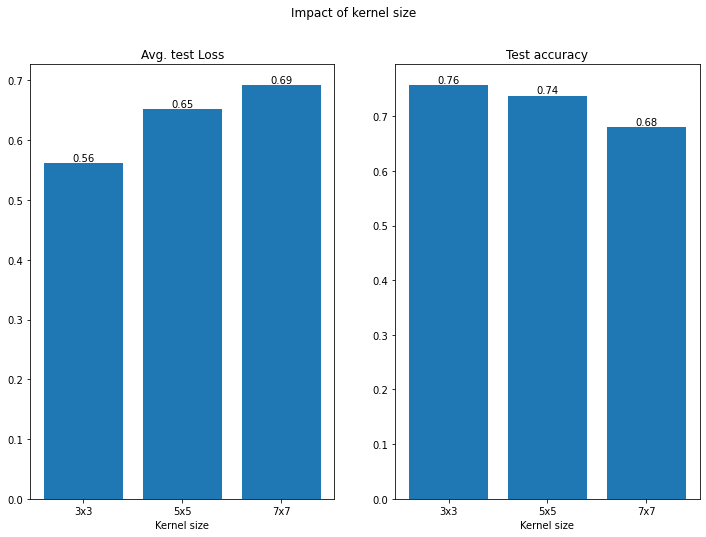

In [27]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Impact of kernel size')

ax1 = f.add_subplot(1,2,1)
bars1 = ax1.bar(['3x3', '5x5', '7x7'], [k3_test_loss, k5_test_loss, k7_test_loss])
ax1.set_title('Avg. test Loss')
ax1.set_xlabel('Kernel size')

for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

ax2 = f.add_subplot(1,2,2)
bars2 = ax2.bar(['3x3', '5x5', '7x7'], [k3_test_acc, k5_test_acc, k7_test_acc])
ax2.set_title('Test accuracy')
ax2.set_xlabel('Kernel size')

for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()


<span style='color:green'>### YOUR ANSWER ###</span>

### Experiment 2

In [28]:
### ADD YOUR CODE HERE ###
# Max Pool
model_maxpool = VGGSmallExp(pool_type="max").to(device)

optimizer = optim.SGD(model_maxpool.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_maxpool, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

maxpool_test_loss, maxpool_test_acc = test_model(model_maxpool, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 40.18batch/s, loss=0.723, lr=0.01]


Epoch [1/10], Train Loss: 0.9543, Train Acc: 0.4990, Val Loss: 0.6703, Val Acc: 0.6822, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 44.37batch/s, loss=0.681, lr=0.01]


Epoch [2/10], Train Loss: 0.7223, Train Acc: 0.6760, Val Loss: 0.6923, Val Acc: 0.7000, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 44.20batch/s, loss=0.65, lr=0.001] 


Epoch [3/10], Train Loss: 0.6232, Train Acc: 0.7403, Val Loss: 0.5772, Val Acc: 0.7422, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 44.16batch/s, loss=1.02, lr=0.001] 


Epoch [4/10], Train Loss: 0.5870, Train Acc: 0.7537, Val Loss: 0.5462, Val Acc: 0.7556, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 44.42batch/s, loss=0.23, lr=0.0001] 


Epoch [5/10], Train Loss: 0.5449, Train Acc: 0.7753, Val Loss: 0.5372, Val Acc: 0.7489, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 42.76batch/s, loss=0.628, lr=0.0001]


Epoch [6/10], Train Loss: 0.5450, Train Acc: 0.7807, Val Loss: 0.5344, Val Acc: 0.7511, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 43.62batch/s, loss=0.32, lr=1e-5] 


Epoch [7/10], Train Loss: 0.5388, Train Acc: 0.7777, Val Loss: 0.5341, Val Acc: 0.7489, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 43.52batch/s, loss=0.453, lr=1e-5]


Epoch [8/10], Train Loss: 0.5357, Train Acc: 0.7787, Val Loss: 0.5340, Val Acc: 0.7511, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 45.16batch/s, loss=0.336, lr=1e-6]


Epoch [9/10], Train Loss: 0.5433, Train Acc: 0.7813, Val Loss: 0.5340, Val Acc: 0.7533, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 45.17batch/s, loss=0.961, lr=1e-6]


Epoch [10/10], Train Loss: 0.5406, Train Acc: 0.7780, Val Loss: 0.5340, Val Acc: 0.7511, Time: 2.3s
Test Loss: 0.5525, Test Accuracy: 0.7622


In [29]:
model_avgpool = VGGSmallExp(pool_type="avg").to(device)

optimizer = optim.SGD(model_avgpool.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_avgpool, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

avgpool_test_loss, avgpool_test_acc = test_model(model_avgpool, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 45.98batch/s, loss=0.906, lr=0.01]


Epoch [1/10], Train Loss: 1.0071, Train Acc: 0.4533, Val Loss: 0.7131, Val Acc: 0.6756, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 45.18batch/s, loss=0.457, lr=0.01]


Epoch [2/10], Train Loss: 0.7706, Train Acc: 0.6613, Val Loss: 0.6738, Val Acc: 0.7044, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 40.34batch/s, loss=0.578, lr=0.001]


Epoch [3/10], Train Loss: 0.6335, Train Acc: 0.7293, Val Loss: 0.5888, Val Acc: 0.7400, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 41.76batch/s, loss=0.608, lr=0.001]


Epoch [4/10], Train Loss: 0.6077, Train Acc: 0.7480, Val Loss: 0.5710, Val Acc: 0.7578, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 44.16batch/s, loss=0.522, lr=0.0001]


Epoch [5/10], Train Loss: 0.5923, Train Acc: 0.7453, Val Loss: 0.5654, Val Acc: 0.7622, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 44.78batch/s, loss=0.492, lr=0.0001]


Epoch [6/10], Train Loss: 0.5872, Train Acc: 0.7553, Val Loss: 0.5639, Val Acc: 0.7622, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 45.85batch/s, loss=0.744, lr=1e-5]


Epoch [7/10], Train Loss: 0.5780, Train Acc: 0.7543, Val Loss: 0.5640, Val Acc: 0.7600, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 46.03batch/s, loss=0.515, lr=1e-5]


Epoch [8/10], Train Loss: 0.5788, Train Acc: 0.7570, Val Loss: 0.5640, Val Acc: 0.7600, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 46.39batch/s, loss=0.666, lr=1e-6]


Epoch [9/10], Train Loss: 0.5815, Train Acc: 0.7530, Val Loss: 0.5640, Val Acc: 0.7600, Time: 2.2s


100%|██████████| 94/94 [00:02<00:00, 46.28batch/s, loss=0.652, lr=1e-6]


Epoch [10/10], Train Loss: 0.5826, Train Acc: 0.7607, Val Loss: 0.5640, Val Acc: 0.7600, Time: 2.2s
Test Loss: 0.6008, Test Accuracy: 0.7467


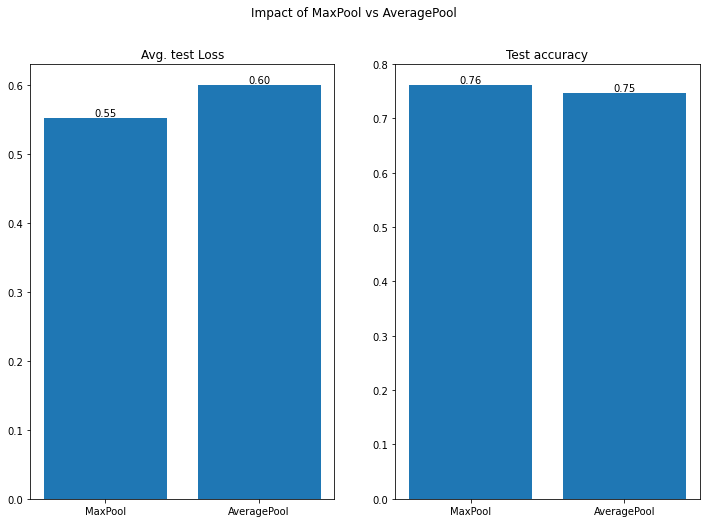

In [36]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Impact of MaxPool vs AveragePool')

ax1 = f.add_subplot(1,2,1)
bars1 = ax1.bar(['MaxPool', 'AveragePool'], [maxpool_test_loss, avgpool_test_loss])
ax1.set_title('Avg. test Loss')


for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

ax2 = f.add_subplot(1,2,2)
bars2 = ax2.bar(['MaxPool', 'AveragePool'], [maxpool_test_acc, avgpool_test_acc])
ax2.set_title('Test accuracy')


for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

<span style='color:green'>### YOUR ANSWER ###</span>

### Experiment 3

In [31]:
### ADD YOUR CODE HERE ###
# Relu 
model_relu = VGGSmallExp(activation="relu").to(device)

optimizer = optim.SGD(model_relu.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_relu, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

relu_test_loss, relu_test_acc = test_model(model_relu, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 43.45batch/s, loss=1.04, lr=0.01] 


Epoch [1/10], Train Loss: 0.9938, Train Acc: 0.4827, Val Loss: 0.7037, Val Acc: 0.7067, Time: 2.4s


100%|██████████| 94/94 [00:01<00:00, 47.20batch/s, loss=0.652, lr=0.01]


Epoch [2/10], Train Loss: 0.7284, Train Acc: 0.6900, Val Loss: 0.7118, Val Acc: 0.7222, Time: 2.2s


100%|██████████| 94/94 [00:02<00:00, 43.12batch/s, loss=0.514, lr=0.001]


Epoch [3/10], Train Loss: 0.6444, Train Acc: 0.7373, Val Loss: 0.5769, Val Acc: 0.7311, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 40.82batch/s, loss=0.547, lr=0.001]


Epoch [4/10], Train Loss: 0.5842, Train Acc: 0.7633, Val Loss: 0.5478, Val Acc: 0.7556, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 44.01batch/s, loss=0.41, lr=0.0001] 


Epoch [5/10], Train Loss: 0.5633, Train Acc: 0.7710, Val Loss: 0.5472, Val Acc: 0.7533, Time: 2.3s


100%|██████████| 94/94 [00:01<00:00, 47.14batch/s, loss=0.453, lr=0.0001]


Epoch [6/10], Train Loss: 0.5639, Train Acc: 0.7677, Val Loss: 0.5464, Val Acc: 0.7600, Time: 2.2s


100%|██████████| 94/94 [00:02<00:00, 46.06batch/s, loss=0.49, lr=1e-5] 


Epoch [7/10], Train Loss: 0.5580, Train Acc: 0.7683, Val Loss: 0.5459, Val Acc: 0.7600, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 44.48batch/s, loss=0.601, lr=1e-5]


Epoch [8/10], Train Loss: 0.5563, Train Acc: 0.7713, Val Loss: 0.5458, Val Acc: 0.7600, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 44.29batch/s, loss=0.38, lr=1e-6] 


Epoch [9/10], Train Loss: 0.5644, Train Acc: 0.7707, Val Loss: 0.5458, Val Acc: 0.7600, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 42.81batch/s, loss=0.531, lr=1e-6]


Epoch [10/10], Train Loss: 0.5643, Train Acc: 0.7647, Val Loss: 0.5458, Val Acc: 0.7600, Time: 2.4s
Test Loss: 0.5673, Test Accuracy: 0.7511


In [32]:
# leaky Relu
model_leakyrelu = VGGSmallExp(activation="leaky").to(device)

optimizer = optim.SGD(model_leakyrelu.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_leakyrelu, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

leaky_test_loss, leaky_test_acc = test_model(model_leakyrelu, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 42.77batch/s, loss=0.902, lr=0.01]


Epoch [1/10], Train Loss: 1.0255, Train Acc: 0.4483, Val Loss: 1.0415, Val Acc: 0.3778, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 42.49batch/s, loss=0.511, lr=0.01]


Epoch [2/10], Train Loss: 0.8599, Train Acc: 0.5990, Val Loss: 0.6523, Val Acc: 0.7200, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 41.99batch/s, loss=0.681, lr=0.001]


Epoch [3/10], Train Loss: 0.6773, Train Acc: 0.7023, Val Loss: 0.6064, Val Acc: 0.7156, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 42.02batch/s, loss=1.03, lr=0.001] 


Epoch [4/10], Train Loss: 0.6451, Train Acc: 0.7243, Val Loss: 0.5932, Val Acc: 0.7289, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 43.77batch/s, loss=0.35, lr=0.0001] 


Epoch [5/10], Train Loss: 0.6211, Train Acc: 0.7337, Val Loss: 0.5860, Val Acc: 0.7333, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 41.56batch/s, loss=0.621, lr=0.0001]


Epoch [6/10], Train Loss: 0.6189, Train Acc: 0.7370, Val Loss: 0.5843, Val Acc: 0.7333, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 42.62batch/s, loss=0.821, lr=1e-5]


Epoch [7/10], Train Loss: 0.6198, Train Acc: 0.7457, Val Loss: 0.5842, Val Acc: 0.7333, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 44.00batch/s, loss=0.47, lr=1e-5] 


Epoch [8/10], Train Loss: 0.6167, Train Acc: 0.7370, Val Loss: 0.5838, Val Acc: 0.7356, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 40.81batch/s, loss=0.631, lr=1e-6]


Epoch [9/10], Train Loss: 0.6112, Train Acc: 0.7410, Val Loss: 0.5838, Val Acc: 0.7356, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 38.91batch/s, loss=0.606, lr=1e-6]


Epoch [10/10], Train Loss: 0.6182, Train Acc: 0.7393, Val Loss: 0.5838, Val Acc: 0.7356, Time: 2.7s
Test Loss: 0.6439, Test Accuracy: 0.7444


In [33]:
# elu
model_elu = VGGSmallExp(activation="elu").to(device)

optimizer = optim.SGD(model_elu.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_elu, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

elu_test_loss, elu_test_acc = test_model(model_elu, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 43.57batch/s, loss=0.489, lr=0.01]


Epoch [1/10], Train Loss: 0.8066, Train Acc: 0.6220, Val Loss: 0.5373, Val Acc: 0.7711, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 43.84batch/s, loss=0.529, lr=0.01]


Epoch [2/10], Train Loss: 0.5771, Train Acc: 0.7707, Val Loss: 0.6534, Val Acc: 0.7178, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 44.21batch/s, loss=0.381, lr=0.001]


Epoch [3/10], Train Loss: 0.4237, Train Acc: 0.8313, Val Loss: 0.4770, Val Acc: 0.8089, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 44.11batch/s, loss=0.457, lr=0.001]


Epoch [4/10], Train Loss: 0.3683, Train Acc: 0.8553, Val Loss: 0.4962, Val Acc: 0.8000, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 41.89batch/s, loss=0.238, lr=0.0001] 


Epoch [5/10], Train Loss: 0.3467, Train Acc: 0.8717, Val Loss: 0.4837, Val Acc: 0.7978, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 40.86batch/s, loss=0.492, lr=0.0001]


Epoch [6/10], Train Loss: 0.3438, Train Acc: 0.8677, Val Loss: 0.4821, Val Acc: 0.7956, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 43.56batch/s, loss=0.312, lr=1e-5]


Epoch [7/10], Train Loss: 0.3349, Train Acc: 0.8717, Val Loss: 0.4823, Val Acc: 0.7956, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 40.04batch/s, loss=0.37, lr=1e-5] 


Epoch [8/10], Train Loss: 0.3379, Train Acc: 0.8710, Val Loss: 0.4823, Val Acc: 0.7978, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 43.81batch/s, loss=0.276, lr=1e-6]


Epoch [9/10], Train Loss: 0.3316, Train Acc: 0.8723, Val Loss: 0.4823, Val Acc: 0.7978, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 41.42batch/s, loss=0.367, lr=1e-6]


Epoch [10/10], Train Loss: 0.3384, Train Acc: 0.8683, Val Loss: 0.4823, Val Acc: 0.7978, Time: 2.5s
Test Loss: 0.5647, Test Accuracy: 0.8178


In [34]:
# gelu
model_gelu = VGGSmallExp(activation="gelu").to(device)

optimizer = optim.SGD(model_gelu.parameters(), lr=0.01, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

train_model(model_gelu, train_subset_loader, val_subset_loader, criterion, optimizer, scheduler, num_epochs)

gelu_test_loss, gelu_test_acc = test_model(model_gelu, test_subset_loader)

100%|██████████| 94/94 [00:02<00:00, 41.09batch/s, loss=1.1, lr=0.01] 


Epoch [1/10], Train Loss: 1.0952, Train Acc: 0.3687, Val Loss: 1.0786, Val Acc: 0.4489, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 40.10batch/s, loss=0.627, lr=0.01]


Epoch [2/10], Train Loss: 0.9100, Train Acc: 0.5733, Val Loss: 0.7707, Val Acc: 0.6244, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 44.58batch/s, loss=1.02, lr=0.001] 


Epoch [3/10], Train Loss: 0.7071, Train Acc: 0.7003, Val Loss: 0.6357, Val Acc: 0.6733, Time: 2.3s


100%|██████████| 94/94 [00:02<00:00, 41.87batch/s, loss=0.521, lr=0.001]


Epoch [4/10], Train Loss: 0.6585, Train Acc: 0.7140, Val Loss: 0.6208, Val Acc: 0.6978, Time: 2.5s


100%|██████████| 94/94 [00:02<00:00, 41.35batch/s, loss=0.777, lr=0.0001]


Epoch [5/10], Train Loss: 0.6524, Train Acc: 0.7200, Val Loss: 0.6172, Val Acc: 0.7000, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 43.58batch/s, loss=0.728, lr=0.0001]


Epoch [6/10], Train Loss: 0.6485, Train Acc: 0.7147, Val Loss: 0.6146, Val Acc: 0.7067, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 41.87batch/s, loss=0.705, lr=1e-5]


Epoch [7/10], Train Loss: 0.6442, Train Acc: 0.7170, Val Loss: 0.6146, Val Acc: 0.7067, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 39.91batch/s, loss=0.543, lr=1e-5]


Epoch [8/10], Train Loss: 0.6390, Train Acc: 0.7200, Val Loss: 0.6144, Val Acc: 0.7067, Time: 2.6s


100%|██████████| 94/94 [00:02<00:00, 43.35batch/s, loss=0.494, lr=1e-6]


Epoch [9/10], Train Loss: 0.6435, Train Acc: 0.7173, Val Loss: 0.6144, Val Acc: 0.7067, Time: 2.4s


100%|██████████| 94/94 [00:02<00:00, 44.08batch/s, loss=0.459, lr=1e-6]


Epoch [10/10], Train Loss: 0.6446, Train Acc: 0.7133, Val Loss: 0.6144, Val Acc: 0.7067, Time: 2.4s
Test Loss: 0.6529, Test Accuracy: 0.7222


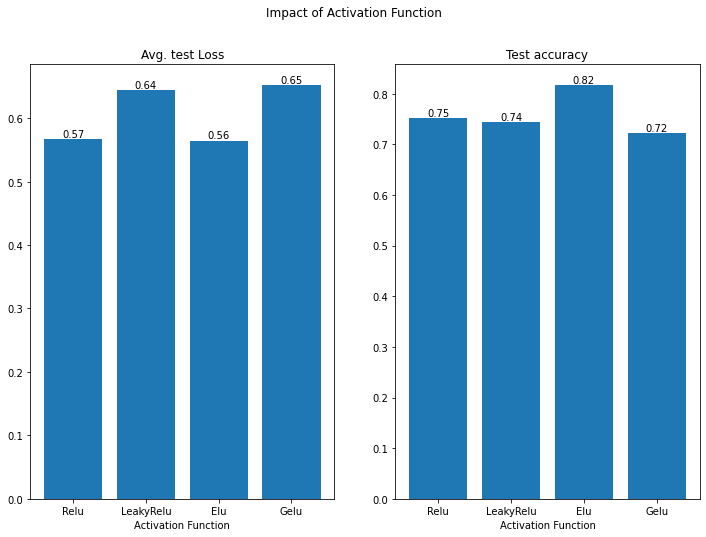

In [35]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Impact of Activation Function')

ax1 = f.add_subplot(1,2,1)
bars1 = ax1.bar(['Relu', 'LeakyRelu', 'Elu', 'Gelu'], [relu_test_loss, leaky_test_loss, elu_test_loss, gelu_test_loss])
ax1.set_title('Avg. test Loss')
ax1.set_xlabel('Activation Function')

for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

ax2 = f.add_subplot(1,2,2)
bars2 = ax2.bar(['Relu', 'LeakyRelu', 'Elu', 'Gelu'], [relu_test_acc, leaky_test_acc, elu_test_acc, gelu_test_acc])
ax2.set_title('Test accuracy')
ax2.set_xlabel('Activation Function')

for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()


<span style='color:green'>### YOUR ANSWER ###</span>

## Step 6: Analysis and discussion

a. Analyze your gradient norm plots. Do they demonstrate the vanishing gradient problem? Explain how the gradient norm changes as you move deeper into VGG-Deep. Be specific and quantitative (e.g., "The gradient norm of layer 2 is X times larger than the gradient norm of layer 10").

<span style='color:green'>Gradient norm of layer 2 is 4 times of last conv layer</span>

b. Explain why the vanishing gradient problem occurs in deep networks. Relate this to the backpropagation algorithm and the chain rule. Discuss how the repeated multiplication of small gradients can lead to extremely small values in earlier layers.

<span style='color:green'>The vanishing gradient problem occurs in deep networks when gradients become extremely small during backpropagation. Since the activation functions we use Relu for instance gives a value between 0 to 1 and generaly it will be less 1 since the value is a decimal and in backprogation we do product of partial derivative hence as the layers increase we keep on multiplying decimal values and hence the values becomes closer to 0 as we do backporgation. As a result the initial layers will cause very poor training accuracy as these layers dont learn the features it is supposed to learn.</span>

c. Explain how ResNet's architecture (residual connections) helps alleviate the vanishing gradient problem. Explain how the identity mapping allows gradients to flow more easily through the network.

<span style='color:green'>ResNet architecture uses residual connections also called as skip connections, since we bypass layers they help the gradient to flow easily during backpropogation. This residual layers helps to carry finner features learned in early layers to further layers smoothing which prevents shrinking. The identity mapping is a small value that is added which prevents the gradient to become zero.</span>

d. Discuss the theoretical impact of batch normalization on the vanishing/exploding gradient problem. Explain how it helps stabilize and accelerate training.

<span style='color:green'>Batch Normalization mitigates the vanishing/exploding gradient problem by normalizing activations within each mini-batch, ensuring that values remain within a stable range throughout training.  Normalizing inputs prevents activations from becoming too large (exploding) or too small (vanishing), Reduces drastic changes in gradients, leading to more stable training. Since activations remain stable we can use larger learning rates, which accelerates convergence.
</span>

e. Summarize the key findings from your three chosen investigations.

<span style='color:green'>
    
**Impact of Kernel Size**
    
Test Loss: Smaller kernel sizes (3×3) resulted in the lowest average test loss (0.56), while larger kernels showed higher loss (0.65 for 5×5 and 0.69 for 7×7)

Test Accuracy: Interestingly, the 3×3 kernel achieved the highest accuracy (0.76), followed by 5×5 (0.74), with 7×7 showing the lowest accuracy (0.68)

Finding: Smaller kernels (3×3) appear optimal for both minimizing loss and maximizing accuracy in this model

**Impact of MaxPool vs AveragePool**
    
Test Loss: MaxPool demonstrated lower test loss (0.55) compared to AveragePool (0.60)

Test Accuracy: MaxPool showed slightly higher accuracy (0.76) versus AveragePool (0.75)

Finding: MaxPool generally outperforms AveragePool, though the accuracy difference is minimal

**Impact of Activation Function**
    
Test Loss: ReLU (0.57) and ELU (0.56) achieved the lowest test losses, while LeakyReLU (0.64) and GeLU (0.65) had higher losses

Test Accuracy: ELU significantly outperformed other activation functions with the highest accuracy (0.82), followed by ReLU (0.75), LeakyReLU (0.74), and GeLU (0.72)

Finding: ELU appears to be the optimal activation function, offering both low loss and substantially higher accuracy than alternatives

**These results suggest that for optimal CNN performance in this context, using 3×3 kernels with MaxPool and ELU activation would likely yield the best result**
    
</span>

f. References. Include details on all the resources used to complete this part.

<span style='color:green'>### YOUR ANSWER ###</span>


https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_full_backward_hook.html